# Seagrass mapping in two mudflats in the Auray River

About a rapid evolution of seagrasses

Simon Oiry [](https://orcid.org/0000-0001-7161-5246) (Nantes Université, UR 2160, F-44000 Nantes, France)  
Bede Ffinian Rowe Davies [](https://orcid.org/0000-0001-6462-4347) (Nantes Université, UR 2160, F-44000 Nantes, France)  
July 9, 2025

Maps of seagrass in two sites in the Auray River. These two sites were studied by Maxime Daviray during his PhD. Seagrass appeared very quickly during his PhD. This work aims to describe this rapid evolution of seagrasses.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attachement du package : 'tidyterra'

L'objet suivant est masqué depuis 'package:stats':

    filter

terra 1.8.50

Attachement du package : 'terra'

L'objet suivant est masqué depuis 'package:tidyr':

    extract


Attachement du package : 'patchwork'

L'objet suivant est masqué depuis 'package:terra':

    area


Attachement du package : 'gridExtra'

L'objet suivant est masqué depuis 'package:dplyr':

    combine


Attachement du package : 'ggrastr'

L'objet suivant est masqué depuis 'package:terra':

    rasterize

Le chargement a nécessité le package : cowplot

Attachement du package : 'cowplot'

L'objet suivant est masqué depuis 'package:patchwork':

    align_plots

L'objet suivant est masqué depuis 'package:lubridate':

    stamp

Le chargement a nécessité le package : magrittr

Attachement du package : 'magrittr'

Les objets suivants sont masqués depuis 'package:terra':

    extract, inset

L'objet suivant est masqué depuis 'package:purrr':

    set_names

L'objet suivant est masqué depuis 'package:tidyr':

    extract

In [ ]:
model <- rast(rgb_list$path_rgb[1])
img2024 <- rast("Data/RGB/T30TVT_20240808T110619_TCI_10m.jp2") %>% 
  crop(ext(model)) %>% 
  resample(model)

writeRaster(img2024,"Data/RGB/2024_RGB.tiff", overwrite = T)

The data and scripts used for this work can be found [here](https://github.com/SigOiry/Seagrass_maps_Maxime).

# Materials & Methods

## Seagrass mapping using Sentinel-2

To map the seagrass extent over time, the Sentinel-2 constellation was used. Level-2 images, which are already orthorectified and atmospherically corrected, were downloaded from the Copernicus Platform \[@Copernicus_Sentinel\]. For most years, one low-tide, cloud-free image per year—closest to the period of peak annual seagrass biomass at this latitude—was selected. However, during the sampling years (2021–2022), all available low-tide, cloud-free images were used to characterize seagrass phenology. In total, 21 images were used (@tbl-tide-data).

| Acquisition Date (UTC) | Low Tide Time (UTC) | Time Difference with Low tide |
|:---------------------:|:------------------:|:---------------------------:|
|    2016-11-03 11:12    |       12 : 08       |          \- 00 : 56           |
|    2017-10-04 11:08    |       09 : 09       |          \+ 01 : 59           |
|    2018-09-29 11:08    |       12 : 43       |          \- 01 : 35           |
|    2019-09-14 11:06    |       10 : 28       |          \+ 00 : 38           |
|    2020-08-04 11:06    |       10 : 45       |          \+ 00 : 21           |
|    2021-10-08 11:09    |       11 : 18       |          \- 00 : 09           |
|    2022-01-21 11:12    |       12 : 30       |          \- 01 : 18           |
|    2022-03-07 11:09    |       13 : 19       |          \- 02 : 10           |
|    2022-03-17 11:08    |       09 : 59       |          \+ 01 : 09           |
|    2022-03-22 11:06    |       12 : 59       |          \- 01 : 53           |
|    2022-06-15 11:06    |       10 : 40       |          \+ 00 : 26           |
|    2022-06-30 11:06    |       11 : 01       |          \+ 00 : 05           |
|    2022-07-15 11:06    |       11 : 19       |          \- 00 : 13           |
|    2022-07-30 11:06    |       11 : 17       |          \- 00 : 11           |
|    2022-08-29 11:06    |       11 : 27       |          \- 00 : 21           |
|    2022-11-12 11:13    |       12 : 26       |          \- 01 : 13           |
|    2023-01-12 11:13    |       13 : 34       |          \- 02 : 21           |
|    2023-02-20 11:11    |       10 : 34       |          \+ 00 : 37           |
|    2023-06-05 11:06    |       10 : 55       |          \+ 00 : 11           |
|    2023-09-03 11:06    |       12 : 28       |          \- 01 : 22           |
|    2024-08-08 11:09    |       12 : 32       |          \- 01 : 23           |

The *Intertidal Classification of Europe: Categorising Reflectance of Emerged Areas of Marine vegetation with Sentinel-2* model has been applied to each Sentinel-2 image (ICE CREAMS, @Davies2024). It is a neural network classifier designed to identify and discriminate intertidal vegetation in Europe. Pixels of the Magnoliopsida class (seagrasses) have been isolated, and the Normalized Difference Vegetation Index (NDVI, @rouse1974monitoring), a commonly used remote sensing biomass proxy for vegetation, has been employed. The equation of @zoffoli2020sentinel have been used to transform NDVI values into Seagrass Percent Cover (\[@eq-std\]). Only pixels with SPC values above 20%, corresponding to high biomass pixel have been considered in order to avoid confusion with other class of vegetation.

$$
SPC = 172.06 \times NDVI - 22.18
$$ {#eq-std}

Maps and analysis have then been performed using the *Terra* package of R, in a *Tidyverse* workflow \[@hijmans2023terra; @wickham2017easily\].

The total extent of each site/date is represented as an absolute area, taking into account the seagrass density of each pixel.

$$
\text{Extent}_{s,d} = \sum_{i=1}^{N_{s,d}} A_{\text{pixel}} \cdot D_i
$$

where:

-   $\text{Extent}_{s,d}$ is the total seagrass extent at site $s$ and date $d$  
-   $N_{s,d}$ is the number of pixels classified as seagrass at site $s$ and date $d$  
-   $A_{\text{pixel}} = 100\ \text{m}^2$ is the area of one pixel  
-   $D_i$ is the seagrass density of pixel $i$ (scaled from 0 to 1)

# Results

## Evolution of the spatial distribution of seagrasses over time

The time series of the seagrass percent cover between 2016 and 2024 shows an overall increase in meadow extent at both sites (@fig-Maps). From 2019 onwards, the meadows became denser at Fort Espagnol, particularly in the northern part of the mudflat. At Kerouarc’h, the meadow was limited to small, sparse patches between 2016 and 2019. However, from 2021 onward, the seagrass meadow experienced a rapid expansion, covering almost the entire mudflat.

In [ ]:
rgb_list <- list.files("Data/RGB/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>%
  as_tibble() %>% 
  rename(path_rgb = "value") %>%  
  mutate(name = gsub(".*/","",path_rgb),                 # Extract the filename
         year = substr(name,1,4)) %>% 
  dplyr::select(-name)

img_list <- list.files("Data/ICECREAMS/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>% 
  as_tibble() %>% 
  rename(path_pred = "value") %>% 
  mutate(name = gsub(".*/","",path_pred),                 # Extract the filename
         year = substr(name,12,15),                  # Extract the year from the filename
         date = as.POSIXct(substr(name,12,19), format = "%Y%m%d")) %>% 
  left_join(rgb_list, by = "year")



# Extract and format the date
mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  vect()

for (i in 1:nrow(img_list)) {
  
  pred <- img_list$path_pred[i] %>% 
    rast(lyrs = 5) %>% 
    mask(mask) %>% 
    as.data.frame(xy=T) %>% 
    mutate(SPC20Unknown = case_when(SPC20Unknown < 30 ~ NA,
                     T ~ SPC20Unknown))
    
  rgb <- img_list$path_rgb[i] %>% 
    rast()

    for(site_i in 1:length(unique(mask$Site_Name))){
      
      if(site_i == 1){
        pts <- data.frame(x = 503531.927,
                          y = 5273622.724) %>% 
          vect(geom=c("x", "y"), crs = crs(mask))
        
        SPC_site_1 <- img_list$path_pred[i] %>% 
          rast(lyrs = 5) %>% 
        terra::extract(pts) %>% 
        pull(SPC20Unknown) %>% 
        round()
      
      }else{
        pts <- data.frame(x = 503383.759,
                          y = 5269955.079) %>% 
          vect(geom=c("x", "y"), crs = crs(mask))
        
        SPC_site_2 <- img_list$path_pred[i] %>% 
          rast(lyrs = 5) %>% 
        terra::extract(pts) %>% 
        pull(SPC20Unknown) %>% 
        round()
      }
      
      
      
      site <- unique(mask$Site_Name)[site_i]
    
      # Extract the mask for the current site
      ext <- mask[which(mask$Site_Name == site)] %>% 
        ext()
      
      resize_x <- (as.numeric(ext[2])- as.numeric(ext[1]))*0.2
      resize_y <- (as.numeric(ext[4])- as.numeric(ext[3]))*0.15

      text_position_x <- as.numeric(ext[1] + ((as.numeric(ext[2])- as.numeric(ext[1]))*0.1))
      text_position_y <- as.numeric(ext[3] - ((as.numeric(ext[4])- as.numeric(ext[3]))*0.12))

      
      plot <- ggplot()+
        geom_spatraster_rgb(data = rgb,
                            max_col_value = 0.8)+
        coord_sf(xlim = c(ext[1]-resize_x, ext[2]+resize_x),
                ylim = c(ext[3]-resize_y, ext[4]+resize_y)) +
        # geom_text(aes(x = text_position_x, y = text_position_y, label = img_list$year[i]), color = "white" , size = 5)+
        scale_fill_viridis_c(na.value = "transparent")+
        theme(axis.text = element_blank(),
              axis.title = element_blank(),
              axis.ticks = element_blank(),
              plot.margin = margin(0, 0, 0, 0, "mm"))
    
      if(site_i == 1){
        a <- plot +
          geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown), show.legend = F) + 
          geom_point(aes(x=503531.927,
                         y=5273622.724), color = "darkred", size = 5)+# Use a continuous color scale and make NA values transparent

          geom_text(aes(x = 503360, y = 5274145, label = "Fort Espagnol" ), color = "white" , size = 7) +
          geom_text(aes(x = 503275.7, y = 5274073, label = img_list$year[i]), color = "white" , size = 7)
        
        if(img_list$year[i]=="2016"){
          a <- a +
            geom_rect(aes(xmin = 503436, xmax = 503738, ymin = 5273032, ymax = 5273120), fill = "white", alpha = 0.4)+
            ggspatial::annotation_scale(location = "br",
                                  text_cex=2,
                                  bar_cols = c("white", "black"))+
               ggforce::geom_mark_ellipse(aes(x=503531.927,
                         y=5273622.724,
                         label = "4B") ,
                         linewidth=0.3,
                         fill="darkred",
                         color = NA,
                         show.legend=F,
                         label.hjust = 0.5,
                         con.size = 2,
                         con.colour = "darkred",
                         label.fontsize = c(25,20),
                         alpha=0,
                         expand = unit(2, "mm") , 
                         radius = unit(2, "mm") , 
                         label.buffer = unit(10, "mm") ,
                         label.fill = rgb(1,1,1,0.4))
        }
        
        if(SPC_site_1 != 0){
          a = a + geom_text(aes(x = 503331.7, y = 5273103, label = paste0("SPC : ", SPC_site_1,"%")), color = "white" , size = 7)
        }
      }else{
        b = plot +
          geom_text(aes(x = 502650, y = 5271835, label = "Kerouarc'h" ), color = "white" , size = 7)
      
        if(img_list$year[i]=="2016"){
          
          b <- b + geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown))  +
                labs(fill = "SPC (%)")+
                geom_rect(aes(xmin = 503282, xmax = 504282, ymin = 5269000, ymax = 5269250), fill = "white", alpha = 0.4)+
                theme(legend.position = c(.9,.85),
                      legend.background = element_rect(fill=scales::alpha('white', 0.4)),
                      legend.text = element_text(size = 15),
                      legend.title = element_text(size = 18,margin = margin(b = 15)),
                      legend.key.size = unit(0.7,"cm")
                      )+
                ggspatial::annotation_scale(location = "br",
                                    text_cex=2,
                                    bar_cols = c("white", "black"))+
            geom_point(aes(x=503383.759,
                         y=5269955.079), color = "darkred", size = 5)+
            ggforce::geom_mark_ellipse(aes(x=503383.759,
                     y=5269955.079,
                     label = "2C") ,
                     linewidth=0.3,
                     fill="darkred",
                     color = NA,
                     show.legend=F,
                     label.hjust = 0.5,
                     con.size = 2,
                     con.colour = "darkred",
                     label.fontsize = c(25,20),
                     alpha=0,
                     expand = unit(2, "mm") , 
                     radius = unit(2, "mm") , 
                     label.buffer = unit(10, "mm") ,
                     label.fill = rgb(1,1,1,0.4))

        }else{
          b = b + geom_tile(data = pred, aes(x = x, y = y, fill = SPC20Unknown), show.legend = F)+
            geom_point(aes(x=503383.759,
                         y=5269955.079), color = "darkred", size = 5)
        }
        
        if(SPC_site_2 != 0){
            b = b +
                 geom_text(aes(x = 502670, y = 5269205, label =  paste0("SPC : ", SPC_site_2,"%")), color = "white" , size = 7)

        }
      }
      
      
    }
  
  patchwork <- a+b
  ggsave(paste0("Output/Figs/maps/",img_list$year[i],"_maps.png"),patchwork, width = 832*3, height = 759*3, units = "px" )
}


read_png_as_ggplot <- function(file_path) {
  img <- readPNG(file_path)
  img_grob <- grid::rasterGrob(img, interpolate = TRUE)
   return(ggplot() +
    annotation_custom(img_grob, xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf) +
    theme_void())
}

png_files <- list.files(path = "Output/Figs/maps", pattern = "*.png", full.names = TRUE)

# Create a list of ggplot objects
plot_list <- lapply(png_files, read_png_as_ggplot)

# Combine plots into one
combined_plot <- do.call(grid.arrange, c(plot_list, ncol = 4))  # Change ncol to adjust the number of columns

ggsave("Output/Figs/Figure1.png",combined_plot, width = 2620*2, height = (2620*2)/2.3, units = "px")
ggsave("Manuscript/Figs/Figure1.png", combined_plot, width = 1000 * 4, height = (500 * 4), units = "px")

In [ ]:
rgb_list <- list.files("Data/RGB/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>%
  as_tibble() %>% 
  rename(path_rgb = "value") %>%  
  mutate(name = gsub(".*/","",path_rgb),                 # Extract the filename
         year = substr(name,1,4)) %>% 
  dplyr::select(-name) %>% 
  arrange(year)

img_list <- list.files("Data/ICECREAMS/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>% 
  as_tibble() %>% 
  rename(path_pred = "value") %>% 
  mutate(name = gsub(".*/","",path_pred),                 # Extract the filename
         year = substr(name,12,15),                  # Extract the year from the filename
         date = as.POSIXct(substr(name,12,19), format = "%Y%m%d")) %>% 
  left_join(rgb_list, by = "year") %>% 
  dplyr::filter(!str_detect(path_pred, "Monthly"))%>% 
  arrange(year)

# Extract and format the date
mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  vect() 


for (i in 1:nrow(img_list)) {
  
  if(i == 9){
   a <- rast(img_list$path_pred[i],lyrs = 4) %>% 
     extend(ext(stk_pred))
  }else{
   a <- rast(img_list$path_pred[i],lyrs = 5)
  }
  
  if(i == 1){
    stk_pred <- a
  }else{
    stk_pred <- c(stk_pred,a)
  }
  
}


sampling_point <- data.frame(x = c(503531.927, 503383.759),
                          y = c(5273622.724,5269955.079)) %>% 
          vect(geom=c("x", "y"), crs = crs(mask))
        
SPC_Sampling <- terra::extract(stk_pred,sampling_point)

names(SPC_Sampling) <- c("ID",img_list$year) 

Sampling_points <- SPC_Sampling %>% 
  pivot_longer(-ID, names_to = "year", values_to = "SPC") %>% 
  mutate(site = case_when(ID == 1 ~ "2C",
                          T ~ "4B"),
         x = case_when(ID == 2 ~ 503383.759,
                          T ~ 503531.927),
         y = case_when(ID == 2 ~ 5269955.079,
                          T ~ 5273622.724),
         x0 = case_when(ID == 2 ~ 503383.759,
                          T ~ 503531.927),
         y0 = case_when(ID == 2 ~ 5269955.079,
                          T ~ 5273622.724),
         SPC_chr = case_when(SPC < 20 ~ "< 20 %",
                             T ~ paste0("~ ",round(SPC,0)," %"))) %>% 
  dplyr::select(-ID)







# Step 1: Define reference aspect ratio from Kerouarc'h
ref_extent <- mask %>% 
  filter(Site_Name == "Kerouarc'h") %>% 
  ext()

ref_aspect_ratio <- (xmax(ref_extent) - xmin(ref_extent)) / (ymax(ref_extent) - ymin(ref_extent))

# Step 2: Loop through each site
for (i in 1:nrow(mask)) {
  mask_i <- mask %>% slice(i)
  site_name <- mask_i$Site_Name
  
  # --- Crop prediction stack using mask only ---
  stk_pred_i <- stk_pred %>% crop(mask_i, mask = TRUE)

  df_pred <- stk_pred_i %>% as.data.frame(xy = TRUE)
  names(df_pred) <- c("x", "y", img_list$year)

  df_pred_plot <- df_pred %>% 
    pivot_longer(-c("x", "y"), names_to = "year", values_to = "SPC") %>% 
    filter(SPC > 30) %>%
    mutate(site = site_name)

  # --- Determine adjusted RGB cropping extent to match reference aspect ratio ---
  pred_ext <- ext(stk_pred_i)

  pred_width  <- xmax(pred_ext) - xmin(pred_ext)
  pred_height <- ymax(pred_ext) - ymin(pred_ext)
  pred_aspect <- pred_width / pred_height

  # Start from the extent of stk_pred_i
  xmin_val <- xmin(pred_ext)
  xmax_val <- xmax(pred_ext)
  ymin_val <- ymin(pred_ext)
  ymax_val <- ymax(pred_ext)

  if (pred_aspect > ref_aspect_ratio) {
    # Too wide → pad height
    target_height <- pred_width / ref_aspect_ratio
    pad <- (target_height - pred_height) / 2
    ymin_val <- ymin_val - pad
    ymax_val <- ymax_val + pad
  } else if (pred_aspect < ref_aspect_ratio) {
    # Too tall → pad width
    target_width <- pred_height * ref_aspect_ratio
    pad <- (target_width - pred_width) / 2
    xmin_val <- xmin_val - pad
    xmax_val <- xmax_val + pad
  }
  # If already matching, do nothing

  # Create adjusted extent for RGB cropping
  rgb_crop_ext <- ext(xmin_val, xmax_val, ymin_val, ymax_val)

  # --- Crop RGB using adjusted extent ---
  stk_rgb <- rast(rgb_list$path_rgb) %>% crop(rgb_crop_ext)

  # Split into RGB triplets and name them
  rgb_list_rast <- map(1:(nlyr(stk_rgb) / 3), ~ stk_rgb[[ ((.x - 1) * 3 + 1):(3 * .x) ]])
  names(rgb_list_rast) <- rgb_list$year

  # Convert each 3-band raster to dataframe
  df_list <- imap(rgb_list_rast, function(r, id) {
    r <- setNames(r, c("R", "G", "B"))
    as.data.frame(r, xy = TRUE) %>%
      mutate(year = id)
  })

  df_all_rgb <- bind_rows(df_list) %>% 
    mutate(site = site_name)

  # --- Combine results ---
  if (i == 1) {
    df_rgb <- df_all_rgb
    df_SPC <- df_pred_plot
  } else {
    df_rgb <- bind_rows(df_rgb, df_all_rgb)
    df_SPC <- bind_rows(df_SPC, df_pred_plot)
  }
}

# All years for Fort Espagnol
years <- unique(df_rgb$year[df_rgb$site == "Fort Espagnol"])

plots <- map(years, function(yr) {
  base_plot <- ggplot() +
    rasterise(geom_raster(data = df_rgb %>% filter(site == "Fort Espagnol", year == yr),
                aes(x = x, y = y, fill = rgb(R, G, B, maxColorValue = 0.9))), dpi = 300) +
    scale_fill_identity() +
    new_scale_fill() +
    geom_tile(data = df_SPC %>% filter(site == "Fort Espagnol", year == yr),
                aes(x = x, y = y, fill = SPC), show.legend = FALSE) +
    scale_fill_viridis_c(name = "SPC") +
               ggforce::geom_mark_ellipse(data = Sampling_points %>% dplyr::filter(site == "2C", year == yr),
                                          mapping = aes(x=x,
                         y=y,
                         # x0 = x+00, 
                         # y0 = y-100,
                         label = site,
                         description = SPC_chr) ,
                         linewidth=0.3,
                         fill="darkred",
                         color = NA,
                         show.legend=F,
                         label.hjust = 0.5,
                         con.size = 1,
                         con.colour = "darkred",
                         label.fontsize = c(15,10),
                         alpha=0.5,
                         expand = unit(1, "mm") , 
                         radius = unit(1, "mm") , 
                         label.buffer = unit(10, "mm") ,
                         label.fill = rgb(1,1,1,0.4))+
    coord_equal() +
    theme_classic() +
    ggtitle(paste("Fort Espagnol –", yr)) +
    theme(
      line = element_blank(),
      axis.text = element_blank(),
      axis.title = element_blank(),
      axis.ticks = element_blank(),
      strip.background = element_blank(),
      plot.title = element_text(size = 9)
    )+
    theme_void()
  
  # Only add scale bar to the first plot
  if (yr == years[1]) {
    base_plot + annotation_scale(location = "bl")
  } else {
    base_plot
  }
})

p1 <- wrap_plots(plots, nrow = 1) + plot_layout(guides = "collect")



# All years for Fort Espagnol
years <- unique(df_rgb$year[df_rgb$site == "Kerouarc'h"])

plots <- map(years, function(yr) {
  base_plot <- ggplot() +
    rasterise(geom_tile(data = df_rgb %>% filter(site == "Kerouarc'h", year == yr),
                aes(x = x, y = y, fill = rgb(R, G, B, maxColorValue = 0.9))), dpi = 300) +
    scale_fill_identity() +
    new_scale_fill() +
    geom_raster(data = df_SPC %>% filter(site == "Kerouarc'h", year == yr),
                aes(x = x, y = y, fill = SPC)) +
    scale_fill_viridis_c(name = "SPC") +
               ggforce::geom_mark_ellipse(data = Sampling_points %>% dplyr::filter(site == "4B", year == yr),
                                          mapping = aes(x=x,
                         y=y,
                         x0 = x+150, 
                         y0 = y-100,
                         label = site,
                         description = SPC_chr) ,
                         linewidth=0.3,
                         fill="darkred",
                         color = NA,
                         show.legend=F,
                         label.hjust = 0.5,
                         con.size = 1,
                         con.colour = "darkred",
                         label.fontsize = c(15,10),
                         alpha=0.5,
                         expand = unit(1, "mm") , 
                         radius = unit(1, "mm") , 
                         label.buffer = unit(10, "mm") ,
                         label.fill = rgb(1,1,1,0.4))+
    coord_equal() +
    theme_classic() +
    ggtitle(paste("Kerouarc'h –", yr)) +
    theme(
      line = element_blank(),
      axis.text = element_blank(),
      axis.title = element_blank(),
      axis.ticks = element_blank(),
      strip.background = element_blank(),
      plot.title = element_text(size = 9)
    )+
    theme_void()
  
  # Only add scale bar to the first plot
  if (yr == years[1]) {
    base_plot + annotation_scale(location = "bl")
  } else {
    base_plot
  }
})

p2 <- wrap_plots(plots, nrow = 1) + plot_layout(guides = "collect")


plot_all <- p1 / p2 + plot_layout(guides = "collect") & theme(legend.position = "bottom")

ggsave("Manuscript/Figs/plot_all.pdf", plot = plot_all, device = cairo_pdf, width = 10, height = 5, dpi = 300)

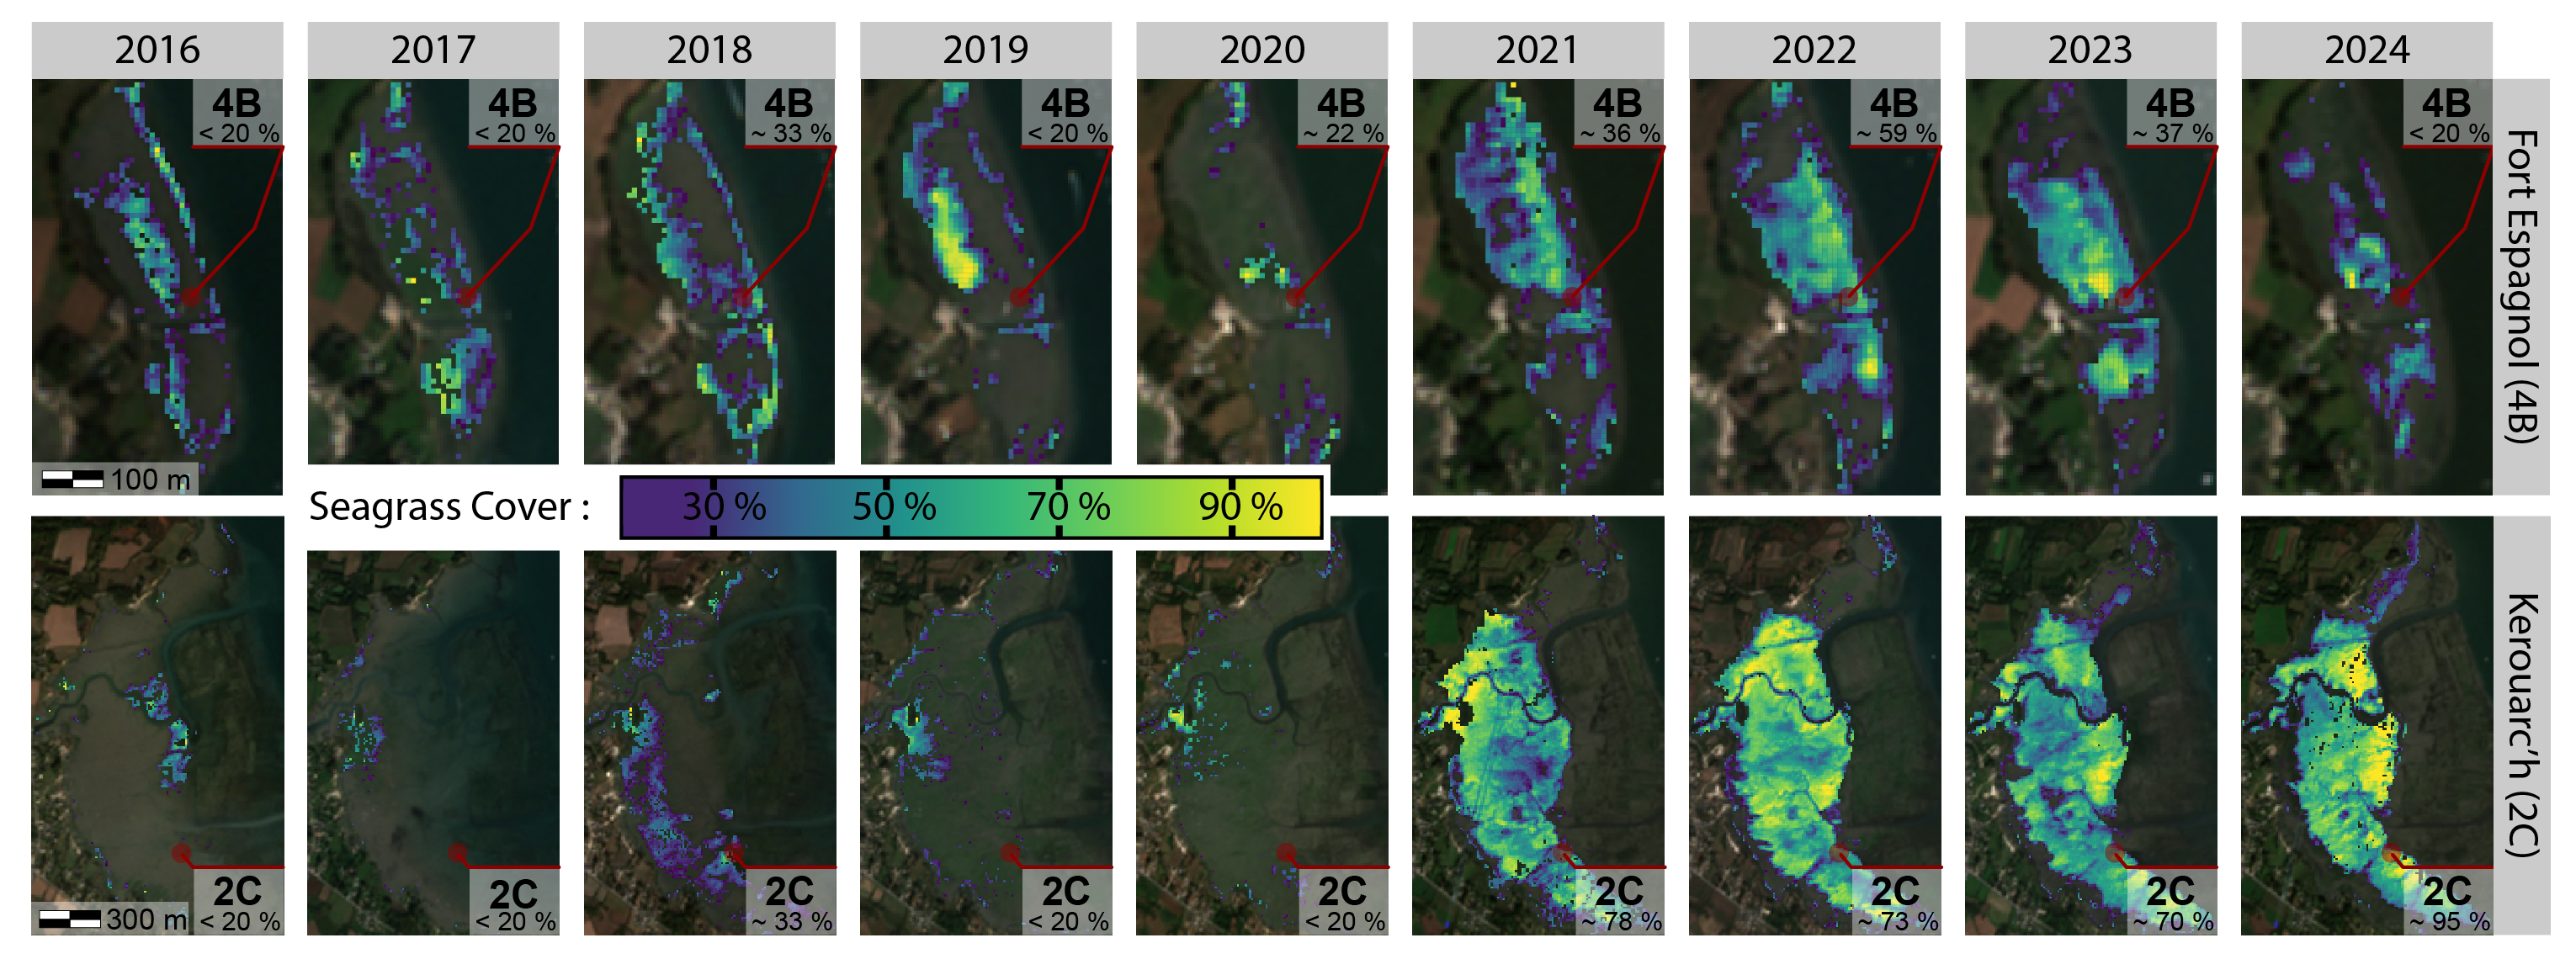

In [ ]:
knitr::include_graphics("Figs/Figure1.png")

## Evolution of the extent and density of the meadow over time

@fig-Extent A) shows the temporal evolution of seagrass meadow extent at both sites. From 2016 onwards, the extent steadily increased, reaching a maximum in 2021 at Fort Espagnol and in 2022 at Kerouarc’h. The only exception to this trend occurred in 2020, due to the presence of green algae overlaying the meadow, which led to an underestimation of its actual extent in the satellite imagery. After reaching their respective peaks, the extent slightly declined at both locations in the following years.

@fig-Extent B) shows the density of meadow over time. Cover remained relatively stable from 2016 to 2020, then increased sharply at both sites, reaching a maximum average of 72% per pixel at Kerouarc’h in 2024 and 54% at Fort Espagnol in 2023. In 2024, however, a marked decline in density is observed at Fort Espagnol, despite the extent of the meadow remaining relatively high.

In [ ]:
# List all .tif files in the "Data/ICECREAMS/" directory, including subdirectories, and convert to a tibble
img_list <- list.files("Data/ICECREAMS/", pattern = ".tif", recursive = TRUE, full.names = TRUE) %>% 
  as_tibble() %>% 
  rename(path = "value") %>% 
  mutate(
    name = gsub(".*/","", path),                 # Extract the filename
    year = substr(name, 12, 15),                 # Extract the year from the filename
    date = as.POSIXct(substr(name, 12, 19), format = "%Y%m%d")  # Extract and format the date
  ) %>% 
  dplyr::filter(!str_detect(path,"Monthly"))

# Load the intertidal mask shapefile
mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  vect()

# Select the mask for a specific site
# mask_site <- mask[which(mask$Site_Name == unique(mask$Site_Name)[site_i])]

# Loop through each image and each site to process the data
for (img_i in 1:nrow(img_list)) {
  for (site_i in 1:length(unique(mask$Site_Name))) {
    
    # Extract the mask for the current site
    mask_site <- mask[which(mask$Site_Name == unique(mask$Site_Name)[site_i])]
    
    # Process the current image
    if(img_i != 9){
      df <- img_list %>% 
        slice(img_i) %>% 
        pull(path) %>% 
        rast() %>% 
        crop(mask_site) %>%                    # Crop the image to the site mask
        as.data.frame(xy = TRUE) %>%           # Convert the raster to a data frame
        mutate(
          site = unique(mask$Site_Name)[site_i],  # Add site information
          date = img_list %>% 
            slice(img_i) %>% 
            pull(date),                   # Add date information
          year = img_list %>% 
            slice(img_i) %>% 
            pull(year) %>% 
            as.numeric()                 # Add year information
        ) %>%               
        dplyr::filter(
          out_class == 4 & SPC20Unknown > 20   # Filter the data for a specific class
        ) %>%        
        as_tibble()
    }else{
      df <- img_list %>% 
        slice(img_i) %>% 
        pull(path) %>% 
        rast() %>% 
        crop(mask_site) %>%                    # Crop the image to the site mask
        as.data.frame(xy = TRUE) %>%           # Convert the raster to a data frame
        mutate(
          site = unique(mask$Site_Name)[site_i],  # Add site information
          date = img_list %>% 
            slice(img_i) %>% 
            pull(date),                   # Add date information
          year = img_list %>% 
            slice(img_i) %>% 
            pull(year) %>% 
            as.numeric()                 # Add year information
        ) %>%               
        dplyr::filter(
          out_class == 4 & SPC20 > 20   # Filter the data for a specific class
        ) %>%        
        as_tibble() %>% 
        mutate(SPC20Unknown = SPC20)
    }
    
    
    # Combine the data frames
    if (img_i == 1 & site_i == 1) {
      output <- df
    } else {
      output <- rbind(output, df)
    }
    
  }
  rm(df)
  rm(mask_site)
}

# Retrieve the area of each site
area <- mask %>% 
  sf::st_as_sf() %>% 
  sf::st_area() %>% 
  as.numeric() %>% 
  as.data.frame() %>% 
  rename(area = ".") %>% 
  mutate(site = unique(output$site))

# Define color scheme for sites
cols <- c("Kerouarc'h (2C)" = "#335145", "Fort Espagnol (4B)" = "#a9d8b8")

# Prepare area data again (seems redundant, might be a mistake)
area <- mask %>% 
  sf::st_as_sf() %>% 
  sf::st_area() %>% 
  as.numeric() %>% 
  as.data.frame() %>% 
  rename(area = ".") %>% 
  mutate(site = unique(output$site))

# Create the plot for relative seagrass extent
plot <- output %>% 
  mutate(site = case_when(site == "Kerouarc'h" ~ "Kerouarc'h (2C)",
                          T ~ "Fort Espagnol (4B)")) %>% 
  group_by(year, site) %>% 
  reframe(seagrass_area = n() * 100 * (10^-6)) %>%
  ungroup() %>% 
  group_by(site) %>% 
  mutate(relative_surface = seagrass_area / max(seagrass_area)) %>% 
  left_join(area, by = "site") %>%
  ggplot() +
  geom_histogram(aes(x = year, y = relative_surface, fill = site), stat = "identity", position = position_dodge(), alpha = 0.8, color = "black", linewidth = 0.5) +
  annotate("text", x = 2015.5, y = 1, label = "A", size = 10) +
  ylab("Relative extent") +
  xlab("Year") +
  scale_fill_manual(values = cols) +
  scale_x_continuous(breaks = c(2016,2017,2018,2019,2020,2021,2022,2023,2024))+
  labs(fill = "Sites:") + 
  theme_bw() +
  theme(
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 15),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17),
    legend.position = "top"
  )

# Boxplot of SPC
plot_SPC <- output %>% 
  mutate(site = case_when(site == "Kerouarc'h" ~ "Kerouarc'h (2C)",
                          T ~ "Fort Espagnol (4B)")) %>% 
  ggplot() + 
  geom_boxplot(aes(x = year, y = SPC20Unknown, fill = site, group = interaction(site, year)), outlier.alpha = 0.1, alpha = 0.8, color = "black", linewidth = 0.5, show.legend = FALSE) +
  annotate("text", x = 2015.5, y = 100, label = "B", size = 10) +
  ylab("Seagrass Cover (%)") +
  xlab("Year") +
  ylim(20, 100) +
  scale_fill_manual(values = cols) +
  labs(fill = "Sites:") + 
  theme_bw() +
  scale_y_continuous(position = "right") +
  scale_x_continuous(breaks = c(2016,2017,2018,2019,2020,2021,2022,2023,2024))+

  theme(
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 15),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17),
    legend.position = "top"
  )

stat_boxplot <- output %>% 
  group_by(site,year) %>% 
  reframe(med = median(SPC20Unknown))

# Combine the two plots and save the figure
a <- plot + plot_SPC
ggsave("Output/Figs/Figure2.png", a, width = 1000 * 4, height = (500 * 4), units = "px")
ggsave("Manuscript/Figs/Figure2.png", a, width = 1000 * 4, height = (500 * 4), units = "px")

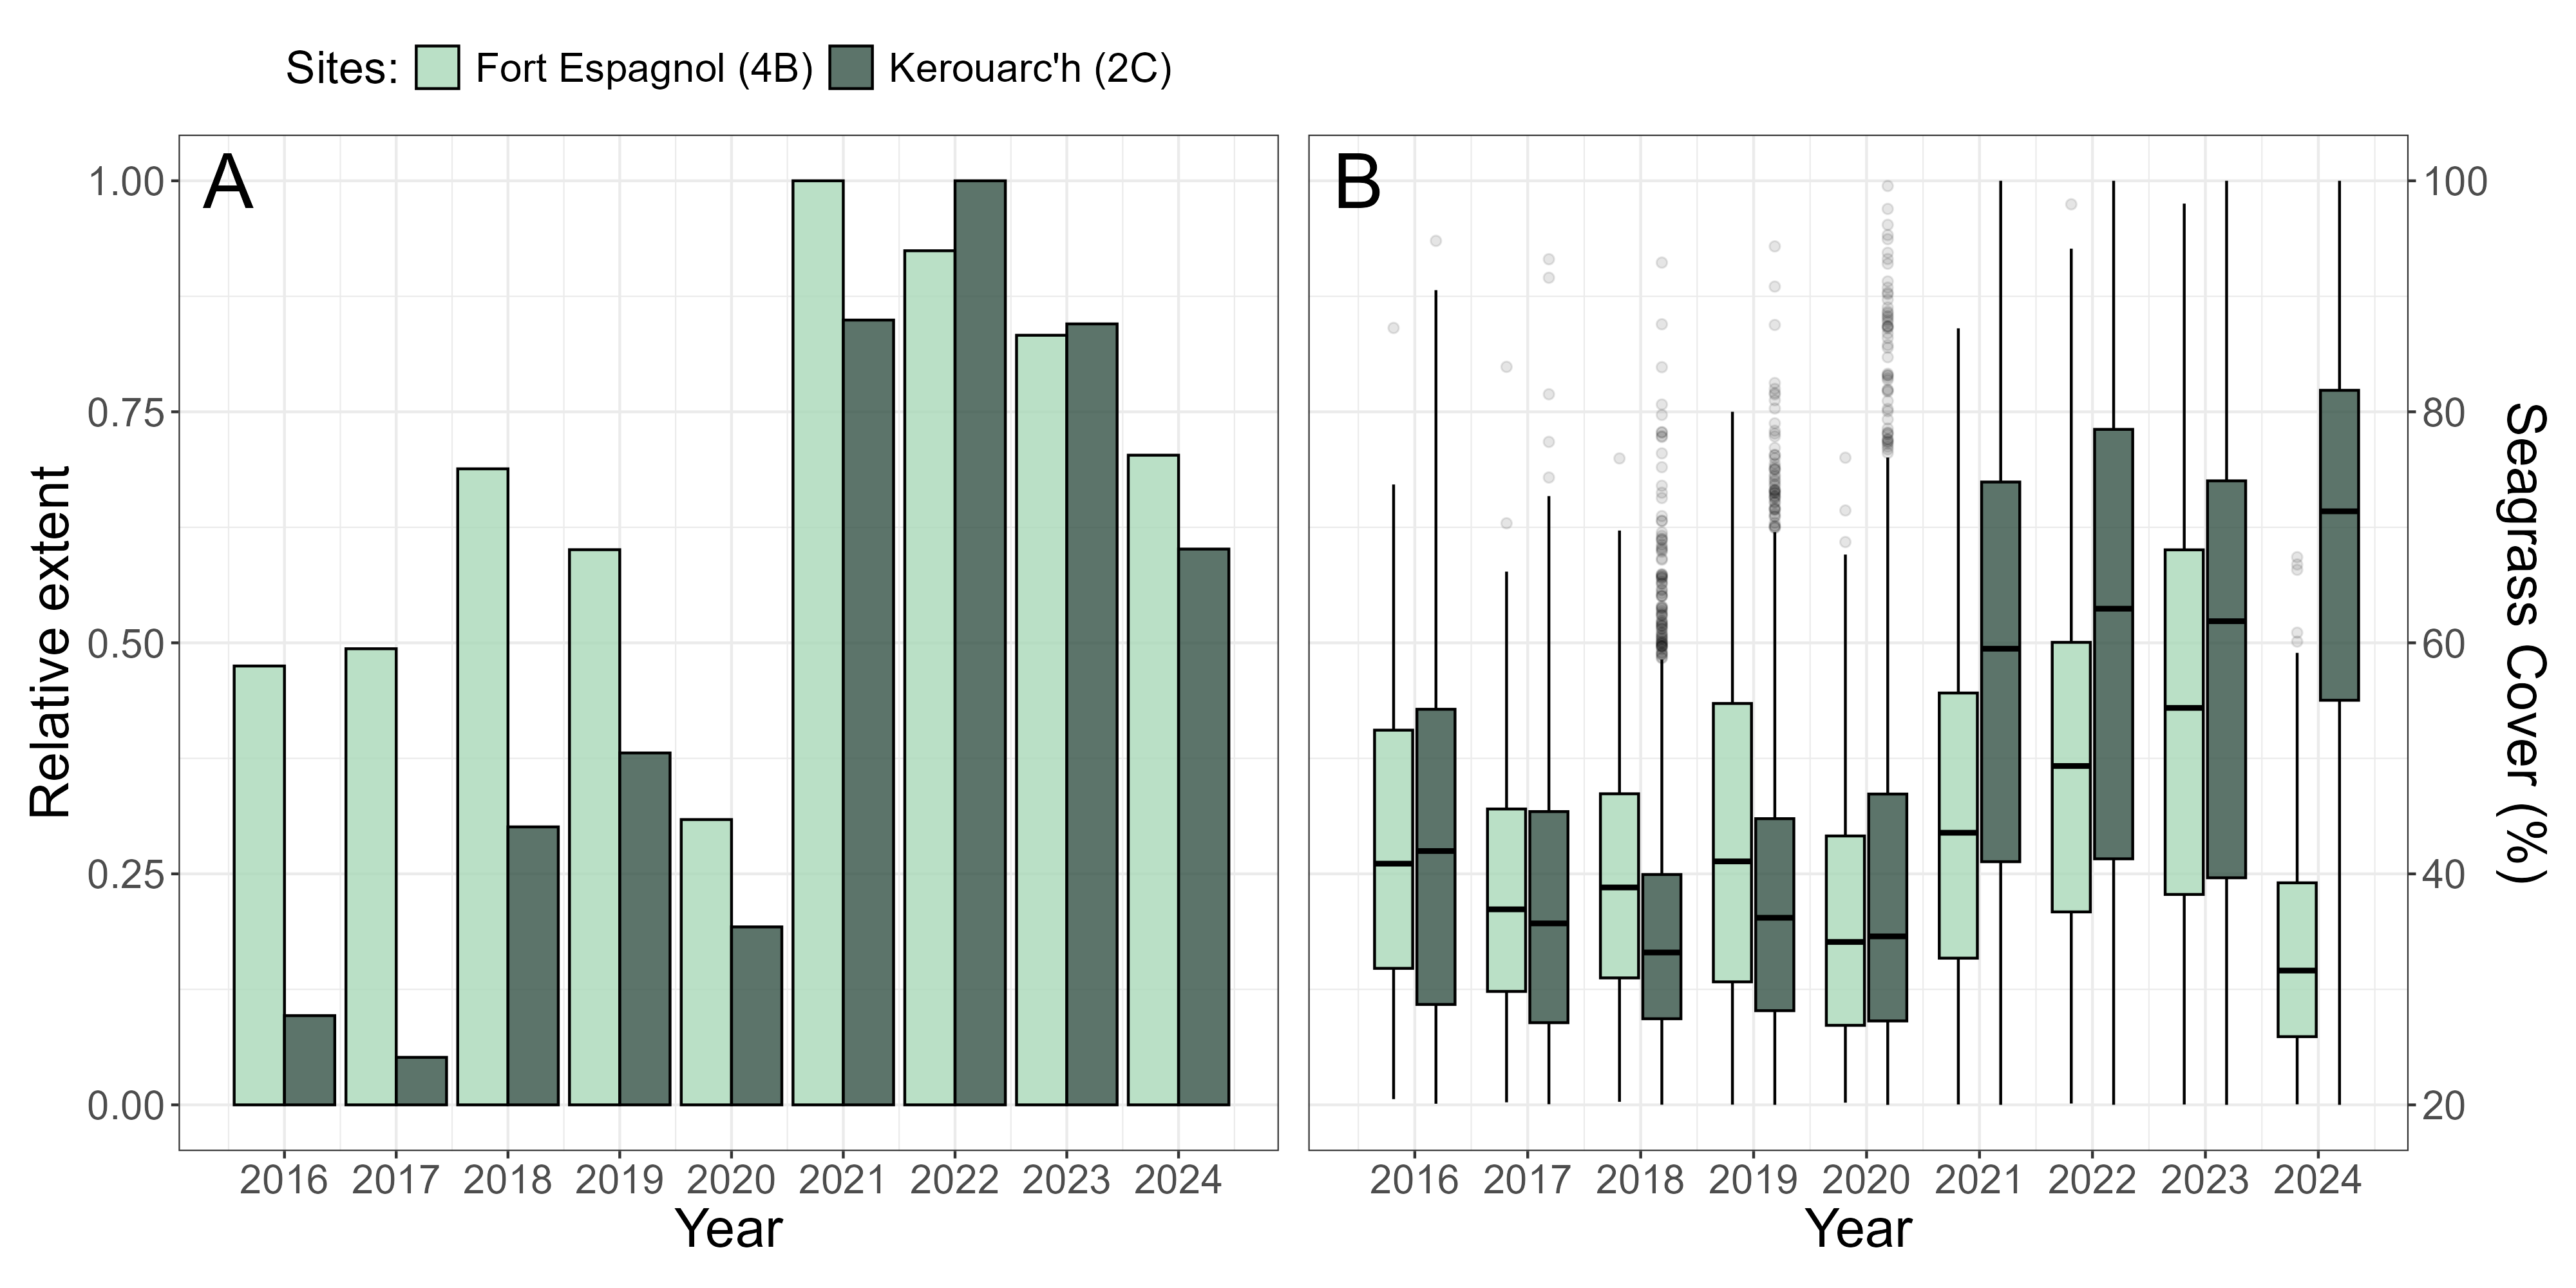

In [ ]:
knitr::include_graphics("Figs/Figure2.png")

## Monthly cover of seagrasses

In [ ]:
library(ggforce)  # for geom_mark_ellipse

filelist <- "Data/ICECREAMS/Monthly" %>% 
  list.files(full.names = T) %>% 
  as_tibble() %>% 
  rename(path = "value") %>% 
  mutate(filename = gsub(".*/","",path),
         date = substr(filename, 12,19) %>% 
           as.Date(format = "%Y%m%d"),
         doy = yday(date)) %>% 
  arrange(date)

cols <- c("Kerouarc'h (2C)" = "#335145", "Fort Espagnol (4B)" = "#7fa38b")

mask <- "Data/mask/Intertidal_mask_Auray.shp" %>% 
  sf::read_sf()
#### Pred

for (i in 1:nrow(filelist)) {
  
  if(i == 1){
    stk_SPC <- rast(filelist$path[i]) %>% 
      dplyr::filter(class_probs > 0.95,
                    SPC > 20)
    stk_SPC <- stk_SPC$out_class
  }else{
    a <- rast(filelist$path[i]) %>% 
      dplyr::filter(class_probs > 0.95,
                    SPC > 20)
    a <- a$SPC
    
    stk_SPC <- c(stk_SPC,a)
  }
  
}
names(stk_SPC) <- filelist$date

sp_mask <- mask %>% 
  dplyr::filter(Site_Name == "Fort Espagnol")
ker_mask <- mask %>% 
  dplyr::filter(Site_Name == "Kerouarc'h")


stk_sp_SPC <- stk_SPC %>% 
  crop(sp_mask, mask = T)

stk_ker_SPC <- stk_SPC %>% 
  crop(ker_mask, mask = T)


df_ker_SPC <- stk_ker_SPC %>% 
  as.data.frame(xy = T) %>% 
  pivot_longer(-c(x,y),names_to = "date", values_to = "SPC") %>% 
  group_by(x,y,date) %>% 
  reframe(relative_area = 10*10*(SPC/100)) %>% 
  ungroup() %>% 
  dplyr::filter(!is.na(relative_area)) %>% 
  group_by(date) %>%
  reframe(area_totale = n()*10*10,
          avg_SPC = mean(relative_area),
          relative_area = sum(relative_area))%>% 
  mutate(date = as.Date(date,format = "%Y-%m-%d"),
         site = "Kerouarc'h")

df_sp_SPC <- stk_sp_SPC %>% 
  as.data.frame(xy = T) %>% 
  pivot_longer(-c(x,y),names_to = "date", values_to = "SPC") %>% 
  group_by(x,y,date) %>% 
  reframe(relative_area = 10*10*(SPC/100)) %>% 
  ungroup() %>% 
  dplyr::filter(!is.na(relative_area)) %>% 
  group_by(date) %>%
  reframe(area_totale = n()*10*10,
          avg_SPC = mean(relative_area),
          relative_area = sum(relative_area)*11)%>% 
  mutate(date = as.Date(date,format = "%Y-%m-%d"),
         site = "Fort Espagnol",
         relative_area = case_when(date < as.Date("2022-06-28") ~ relative_area*0.2,
                                   T ~ relative_area))

df_SPC_all <- rbind(df_sp_SPC,df_ker_SPC) %>% 
  mutate(relative_area = relative_area *0.0001)

Fig_3 <- df_SPC_all %>% 
  mutate(site = case_when(site == "Kerouarc'h" ~ "Kerouarc'h (2C)",
                          T ~ "Fort Espagnol (4B)")) %>%  
  mutate(doy = yday(date)) %>% 
  ggplot(aes(x = date, y = relative_area, color = site)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = cols, name = "Study Site: ") +
  scale_y_continuous(
    name = "Relative area of Kerouarc'h (ha)",
    sec.axis = sec_axis(~ . / 11, name = "Relative area of Fort Espagnol (ha)")
  ) +
  theme_Bede()+
  xlab("Date")+
  theme(
    axis.title.y.left = element_text(color = "#335145", size = 15),
    axis.text.y.left  = element_text(color = "#335145", size = 13),
    axis.ticks.y.left = element_line(color = "#335145"),
    
    axis.title.y.right = element_text(color = "#7fa38b", size = 15),
    axis.text.y.right  = element_text(color = "#7fa38b", size = 13),
    axis.ticks.y.right = element_line(color = "#7fa38b"),
    axis.text.x  = element_text(size = 13),
    legend.position = "top",
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 15)
    
  )

ggsave("Manuscript/Figs/Figure3.png",Fig_3, dpi = 200)

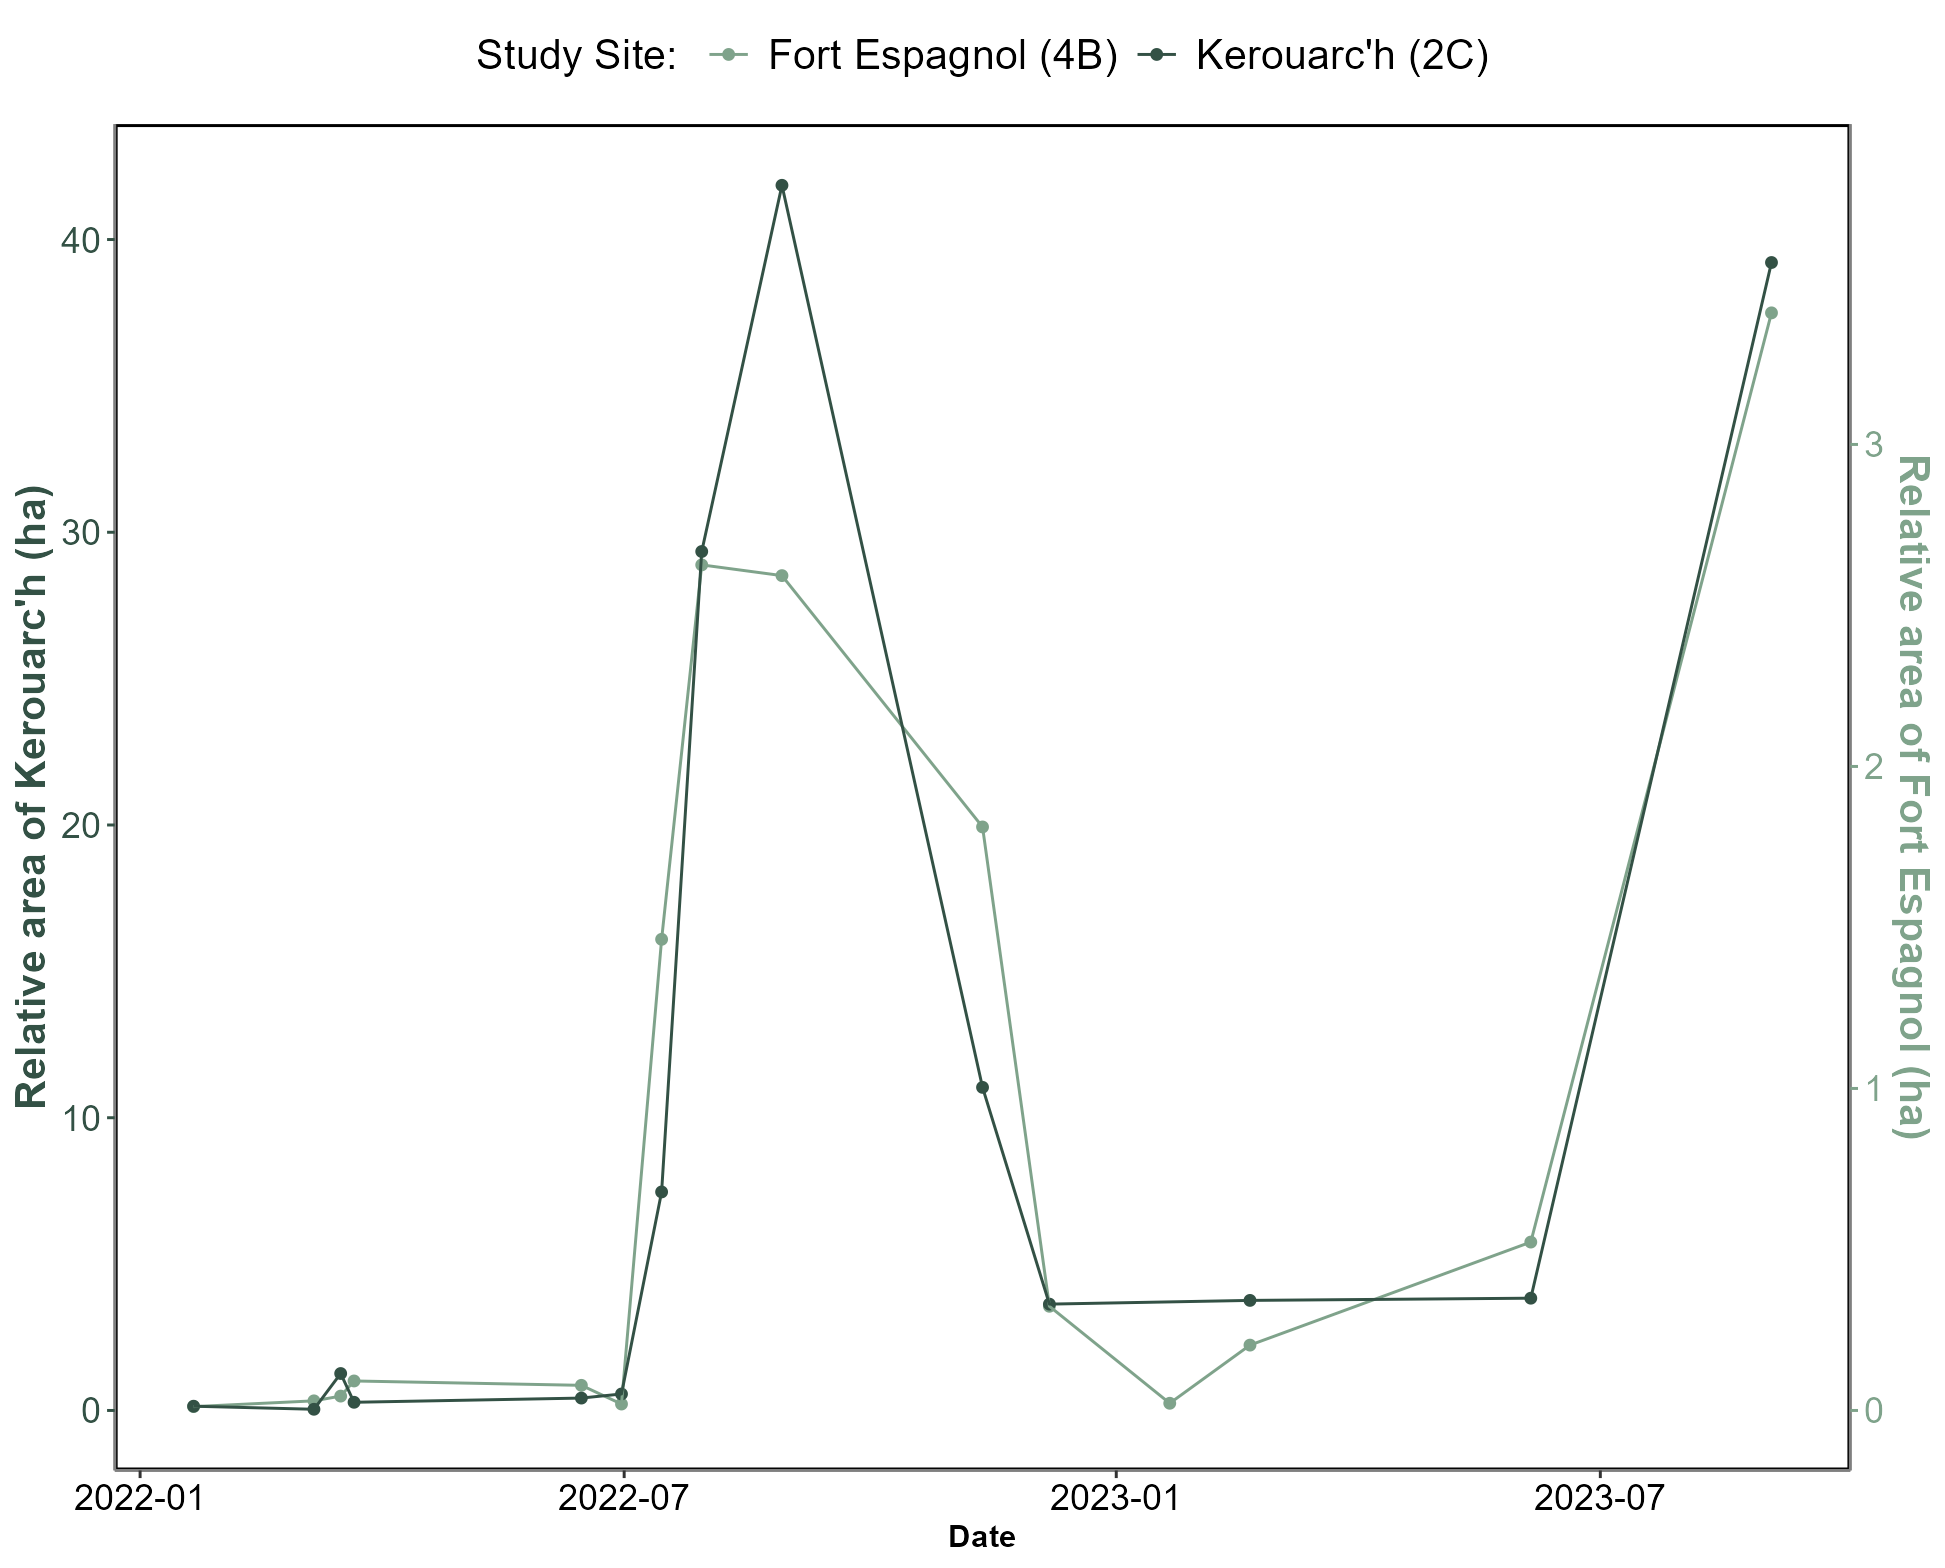

In [ ]:
knitr::include_graphics("Figs/Figure3.png")

@fig-Pheno shows a strong seasonal variation in seagrass cover at both sites. Seagrass cover is nearly absent during winter and begins to increase in early summer (July), reaching peak extent and density around September. Kerouarc’h hosts the largest meadows, covering more than 40 hectares on August 29, 2022, while Fort Espagnol reaches a maximum extent of 2.5 hectares during the same period.